In [70]:
%load_ext autoreload
%autoreload 2
# imports
import logging
import sys, os
import time
from tf_pose import common
import cv2
import numpy as np
from tf_pose.estimator import TfPoseEstimator, PoseEstimator
from tf_pose.networks import get_graph_path, model_wh
from tf_pose.common import CocoPart, CocoPairsRender, CocoPairsNetwork
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import asyncio
import datetime
import random
import websockets
import nest_asyncio
import http.server
import socketserver
import threading
from IPython.display import IFrame
import base64
from PIL import Image
from io import BytesIO
import re
from utils import plot_pose, get_humans_as_lines, plot_human_lines, is_same_image
import tensorflow as tf
import math
import copy
sys.path.insert(0, os.path.abspath('..'))
# Import DeepExplain
from deepexplain.tf.v1_x import DeepExplain

nest_asyncio.apply()

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
logging.getLogger("tensorflow").setLevel(logging.CRITICAL)
logging.getLogger('TfPoseEstimatorRun').setLevel(logging.ERROR)
logging.getLogger('DeepExplain').setLevel(logging.ERROR)
logging.getLogger('TfPoseEstimator').setLevel(logging.ERROR)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# params 432, 368
w, h = 432, 368
image_path_source = './data/images/lea_source.jpg'
image_path_target = './data/images/lea_target_near.jpg'
model = 'cmu'
resize_out_ratio = 2.0
image_source = common.read_imgfile(image_path_source, w, h)
image_target = common.read_imgfile(image_path_target, w, h)
def put_heatmap(heatmap, plane_idx, center, sigma):
        center_x, center_y = center
        _, height, width = heatmap.shape[:3]

        th = 4.6052
        delta = math.sqrt(th * 2)

        x0 = int(max(0, center_x - delta * sigma))
        y0 = int(max(0, center_y - delta * sigma))

        x1 = int(min(width, center_x + delta * sigma))
        y1 = int(min(height, center_y + delta * sigma))

        for y in range(y0, y1):
            for x in range(x0, x1):
                d = (x - center_x) ** 2 + (y - center_y) ** 2
                exp = d / 2.0 / sigma / sigma
                if exp > th:
                    continue
                heatmap[plane_idx][y][x] = max(heatmap[plane_idx][y][x], math.exp(-exp))
                heatmap[plane_idx][y][x] = min(heatmap[plane_idx][y][x], 1.0)

In [3]:
e_source = TfPoseEstimator(get_graph_path(model), target_size=(w, h), trt_bool=False)
e_target = TfPoseEstimator(get_graph_path(model), target_size=(w, h), trt_bool=False)
upsample_size = [int(e_target.target_size[1] / 8 * resize_out_ratio), int(e_target.target_size[0] / 8 * resize_out_ratio)]

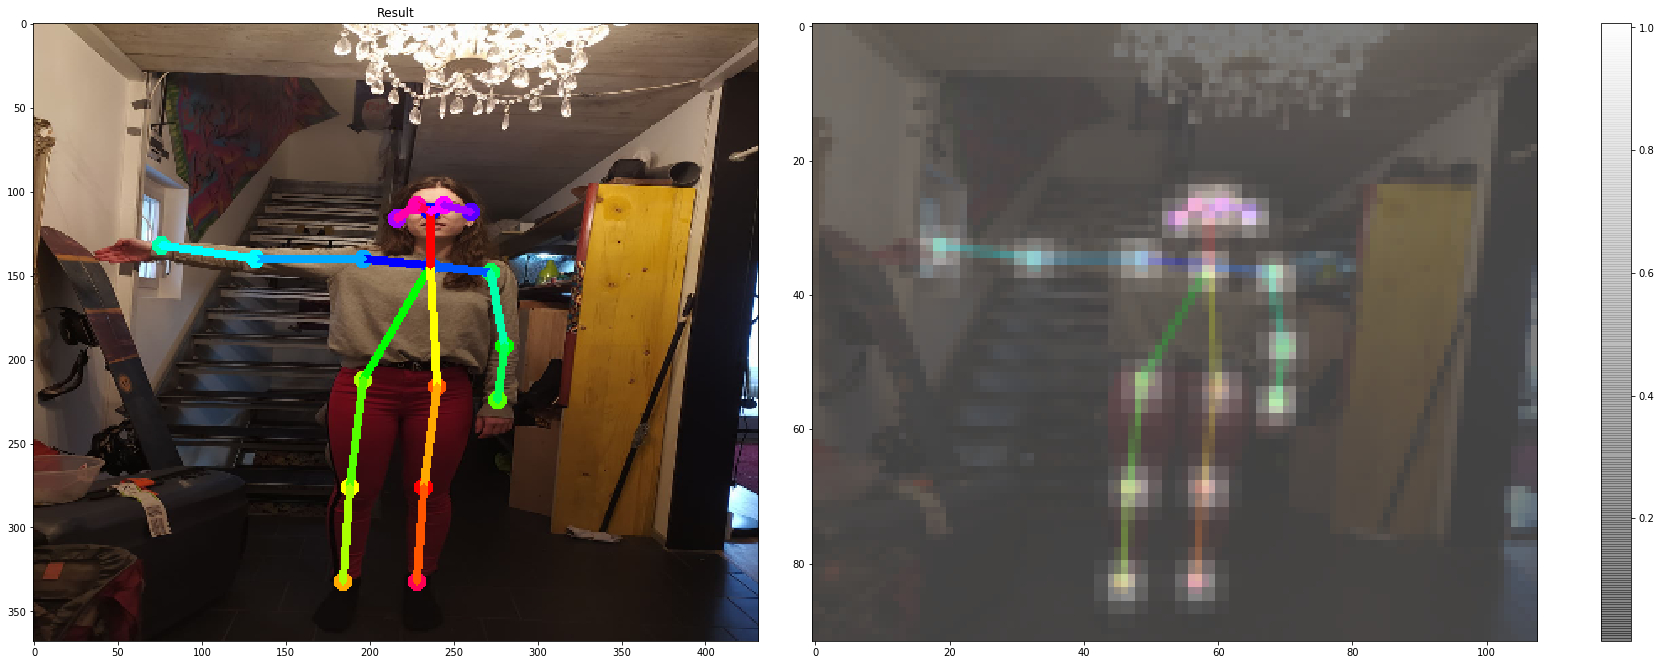

In [4]:
human_source = e_source.inference(image_source, resize_to_default=(w > 0 and h > 0), upsample_size=resize_out_ratio)
plot_pose(image_source, human_source, e_source.heatMat)

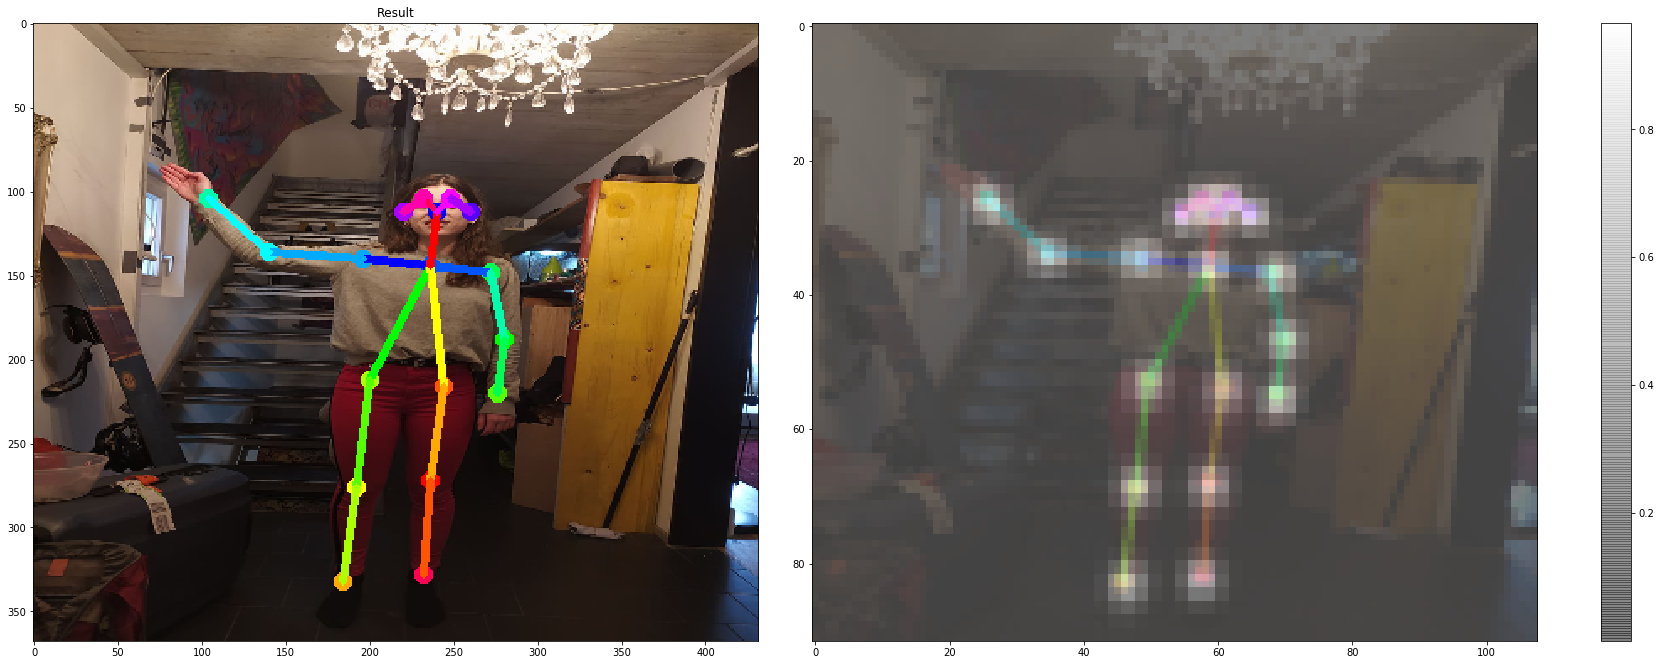

In [5]:
human_target = e_target.inference(image_target, resize_to_default=(w > 0 and h > 0), upsample_size=resize_out_ratio)
plot_pose(image_target, human_target, e_target.heatMat)

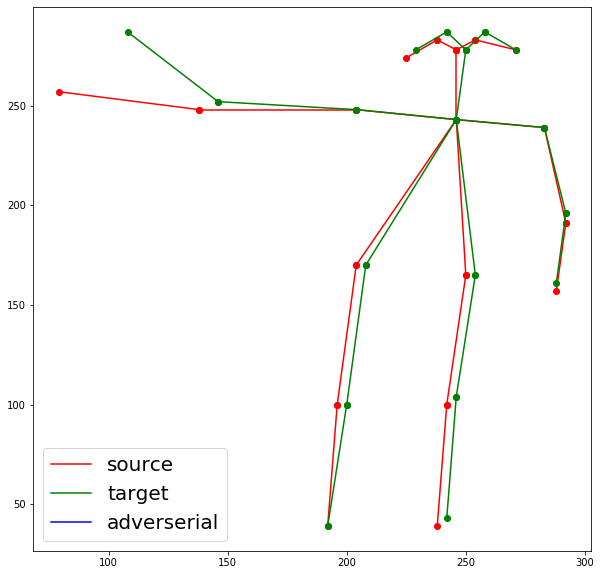

In [6]:
source_lines = get_humans_as_lines(human_source, 400, 450)
target_lines = get_humans_as_lines(human_target, 400, 450)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)

plot_human_lines(source_lines, ax, color='r', linestyle='-', label='source')
plot_human_lines(target_lines, ax, color='g', linestyle='-', label='target')

legend_elements = [Line2D([0], [0], color='r', label='source'),
                   Line2D([0], [0], color='g', label='target'),
                   Line2D([0], [0], color='b', label='adverserial')]
ax.legend(handles=legend_elements, loc='best',  prop={'size': 20})

In [7]:
# get all outputs as np matrix
target_np, target_np_heat, target_np_paf, target_np_peaks = e_target.persistent_sess.run(
            [e_target.tensor_output, e_target.tensor_heatMat_up, e_target.tensor_pafMat_up, e_target.tensor_peaks],
            feed_dict={
                e_target.tensor_image: [image_target],
                e_target.upsample_size: upsample_size
            }
        )

source_np, source_np_heat, source_np_paf, source_np_peaks = e_source.persistent_sess.run(
            [e_source.tensor_output, e_source.tensor_heatMat_up, e_source.tensor_pafMat_up, e_source.tensor_peaks],
            feed_dict={
                e_source.tensor_image: [image_source],
                e_source.upsample_size: upsample_size
            }
        )


In [8]:
# change only the heatmap for the wrist and the required limb vector field
# wrist
temp_target = copy.deepcopy(source_np_heat)
temp_target[:, :, :, CocoPart.RWrist.value] = target_np_heat[:, :, :, CocoPart.RWrist.value]
target_np_heat = temp_target

# lower arm 
LOWER_ARM_RIGTH = 3
temp_target = copy.deepcopy(source_np_paf)
id = CocoPairsNetwork[LOWER_ARM_RIGTH][0]
temp_target[:, :, :, id] = target_np_paf[:, :, :, id]
temp_target[:, :, :, id + 1] = target_np_paf[:, :, :, id + 1]

target_np_paf = temp_target

# set the correct peaks
temp_target = copy.deepcopy(source_np_peaks)
temp_target[:, :, :, CocoPart.RWrist.value] = target_np_peaks[:, :, :, CocoPart.RWrist.value]
target_np_peaks = temp_target

# change the output as well
temp_target = copy.deepcopy(source_np)
temp_target[:, :, :, CocoPart.RWrist.value] = target_np[:, :, :, CocoPart.RWrist.value]
temp_target[:, :, :, id + 19] = target_np[:, :, :, id + 19]
temp_target[:, :, :, id + 19 + 1] = target_np[:, :, :, id + 19 + 1]
target_np = temp_target

(1, 46, 54, 57)
(1, 92, 108, 19)
(1, 92, 108, 38)
(1, 92, 108, 19)


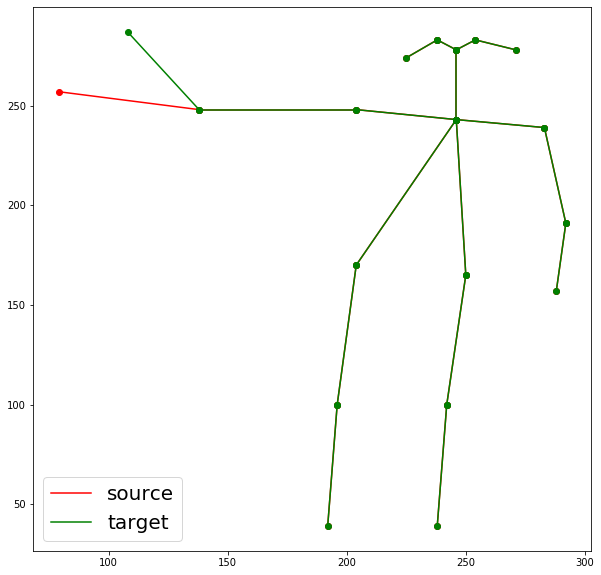

In [43]:
print(target_np.shape)
print(target_np_heat.shape)
print(target_np_paf.shape)
print(target_np_peaks.shape)

# for i in range(52):
#     print(np.sum(np.abs(target_np[:, :, :, i] - source_np[:, :, :, i])))


human_source = PoseEstimator.estimate_paf(source_np_peaks[0], source_np_heat[0], source_np_paf[0])
human_target = PoseEstimator.estimate_paf(target_np_peaks[0], target_np_heat[0], target_np_paf[0])


source_lines = get_humans_as_lines(human_source, 400, 450)
target_lines = get_humans_as_lines(human_target, 400, 450)


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)

plot_human_lines(source_lines, ax, color='r', linestyle='-', label='source')
plot_human_lines(target_lines, ax, color='g', linestyle='-', label='target')

legend_elements = [Line2D([0], [0], color='r', label='source'),
                   Line2D([0], [0], color='g', label='target')]
ax.legend(handles=legend_elements, loc='best',  prop={'size': 20})

In [31]:
# the target state
target_heat = tf.compat.v1.placeholder(tf.float32, shape=(None, None, None, 19))
target_paf = tf.compat.v1.placeholder(tf.float32, shape=(None, None, None, 38))

eps = tf.constant(0.05, name='Epsilon')


losses_per_stage = []
# compute loss per stage
for stage in range(2, 7): 
    paf_op = e_source.graph.get_operation_by_name(f'TfPoseEstimator/Mconv7_stage{stage}_L1/BiasAdd').outputs[0]
    heat_op = e_source.graph.get_operation_by_name(f'TfPoseEstimator/Mconv7_stage{stage}_L2/BiasAdd').outputs[0]
    
    # check if concat works 
    # compute the loss for every channel
    loss_paf = tf.nn.l2_loss(tf.concat(paf_op, axis=-1) - tf.concat(target_paf, axis=-1), name='AX_loss_l1_stage%d_' % (stage))
    loss_heat = tf.nn.l2_loss(tf.concat(heat_op, axis=-1) - tf.concat(target_heat, axis=-1), name='AX_loss_l2_stage%d_' % (stage))
    losses_per_stage.append(tf.reduce_sum([loss_paf, loss_heat]))

# combined loss form every stage
total_loss = tf.reduce_sum(losses_per_stage)


grad = tf.gradients(total_loss, e_source.tensor_image)[0]
x_adv = e_source.tensor_image - eps * tf.sign(grad)
x_adv = tf.clip_by_value(x_adv, -1.0, 1.0)
x_adv = tf.stop_gradient(x_adv)

In [52]:
EPS = 0.1
STEPS = 1

adv_image = copy.deepcopy(image_source)
for i in range(STEPS):    
    # compute gradient
    gradient = e_source.persistent_sess.run(
                grad,
                feed_dict={
                    target_heat: target_np[:, :, :, :19],
                    target_paf: target_np[:, :, :, 19:],
                    e_source.tensor_image: [adv_image],
                    e_source.upsample_size: upsample_size
                }
            )

    # compute loss before applying the gradient
    loss_before = e_source.persistent_sess.run(
                total_loss,
                feed_dict={
                    target_heat: target_np[:, :, :, :19],
                    target_paf: target_np[:, :, :, 19:],
                    e_source.tensor_image: [adv_image],
                    e_source.upsample_size: upsample_size
                }
            )

    print(f'{i}: Loss: {loss_before}')

    adv_image = image_source - EPS * np.sign(gradient[0])




human_source = PoseEstimator.estimate_paf(source_np_peaks[0], source_np_heat[0], source_np_paf[0])
human_target = PoseEstimator.estimate_paf(target_np_peaks[0], target_np_heat[0], target_np_paf[0])

human_adv = e_source.inference(np.clip(adv_image, 0, 255), resize_to_default=(w > 0 and h > 0), upsample_size=resize_out_ratio)


def print_image_Stats(img):
    print(f'Min: {np.min(img)}')
    print(f'Max: {np.max(img)}')
    print(f'Avg: {np.average(img)}')
    
def compare_poses(pose1, pose2):
    total_diff = 0
    cur_max = 0
    most_moved_part = ''
    if(len(pose1.body_parts) != len(pose2.body_parts)):
        print('Poses have different length of body parts')
        return 0, 'NONE'
    for i in pose1.body_parts.keys():
        part1 = pose1.body_parts[i]
        part2 = pose2.body_parts[i]
        part1_pos =  np.array([part1.x, part1.y])
        part2_pos =  np.array([part2.x, part2.y])
        cur_diff = np.linalg.norm(part1_pos - part2_pos)
        if cur_diff > cur_max:
            most_moved_part = part1.get_part_name()
            cur_max = cur_diff
        total_diff += cur_diff
    return total_diff, most_moved_part

    
print_image_Stats(image_source)
print_image_Stats(adv_image)
total_diff, most_moved_part = compare_poses(human_source[0], human_adv[0])
print(f'The total diff is {total_diff} and the part moved the most is the {most_moved_part}')

0: Loss: 63.27656936645508
Min: 0
Max: 255
Avg: 64.82726323470209
Min: -0.10000000149011612
Max: 255.10000610351562
Avg: 64.8274917602539
The total diff is 0.03864734299516909 and the part moved the most is the CocoPart.RElbow


2020-01-20 18:12:54,409 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2020-01-20 18:12:54,426 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 368, 432, 3)


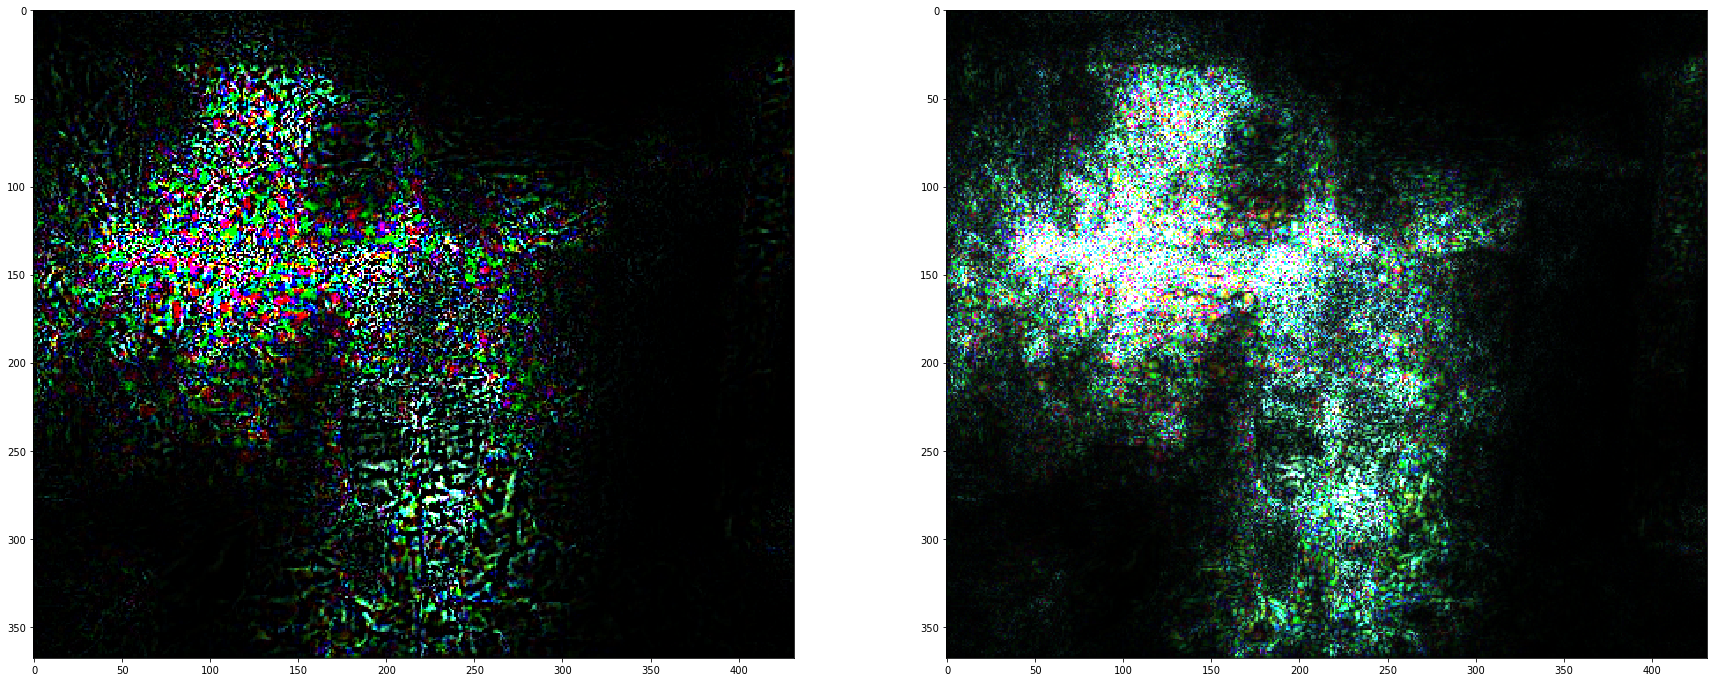

In [79]:
SCALE = 1000
print(gradient.shape)
fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(gradient[0] * SCALE)
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.abs(gradient[0] * SCALE), cmap='hot')

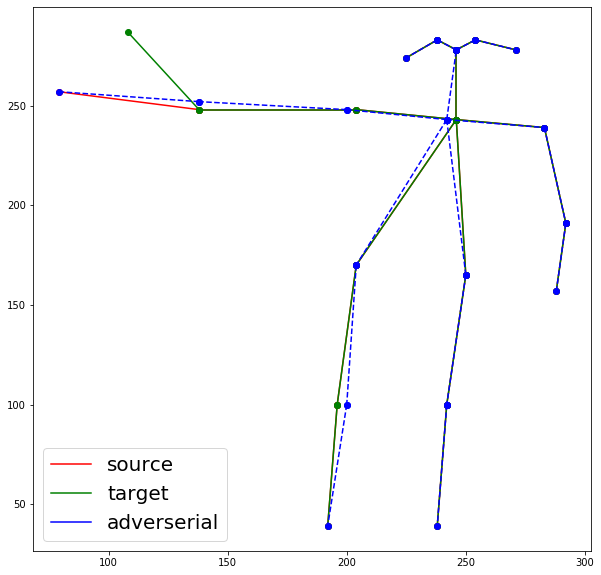

In [54]:
source_lines = get_humans_as_lines(human_source, 400, 450)
target_lines = get_humans_as_lines(human_target, 400, 450)
adv_lines = get_humans_as_lines(human_adv, 400, 450)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)

plot_human_lines(source_lines, ax, color='r', linestyle='-', label='source')
plot_human_lines(target_lines, ax, color='g', linestyle='-', label='target')
plot_human_lines(adv_lines, ax, color='b', linestyle='--', label='adv')

legend_elements = [Line2D([0], [0], color='r', label='source'),
                   Line2D([0], [0], color='g', label='target'),
                   Line2D([0], [0], color='b', label='adverserial')]
ax.legend(handles=legend_elements, loc='best',  prop={'size': 20})

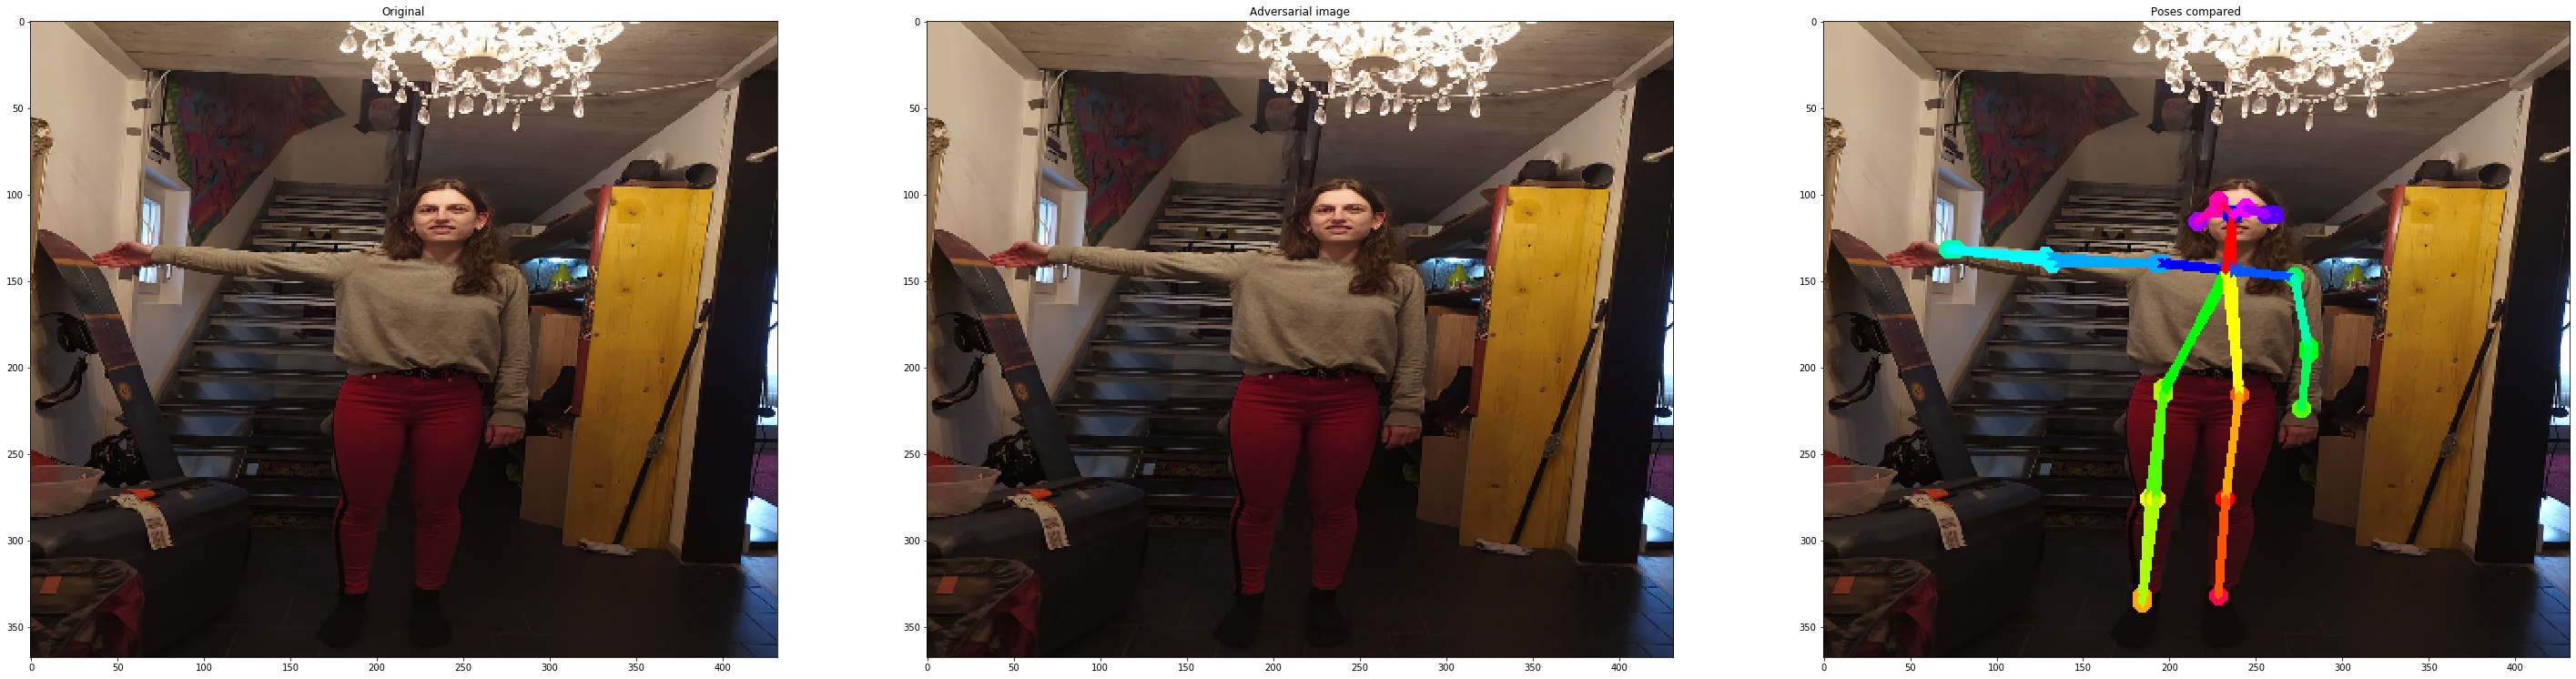

In [36]:
fig = plt.figure(figsize=(50, 25))

ax = fig.add_subplot(1, 3, 1)
ax.imshow(cv2.cvtColor(image_source, cv2.COLOR_BGR2RGB))
ax.set_title('Original')

adv_image_cliped = np.clip(adv_image, 0, 255) / 255
ax = fig.add_subplot(1, 3, 2)
ax.imshow(cv2.cvtColor(adv_image_cliped, cv2.COLOR_BGR2RGB))
ax.set_title('Adversarial image')


image_source_result = TfPoseEstimator.draw_humans(image_source, human_source, imgcopy=True)
image_source_result = TfPoseEstimator.draw_humans(image_source_result, human_adv, imgcopy=True)

ax = fig.add_subplot(1, 3, 3)
ax.set_title('Poses compared')
ax.imshow(cv2.cvtColor(image_source_result, cv2.COLOR_BGR2RGB))

3.2700553


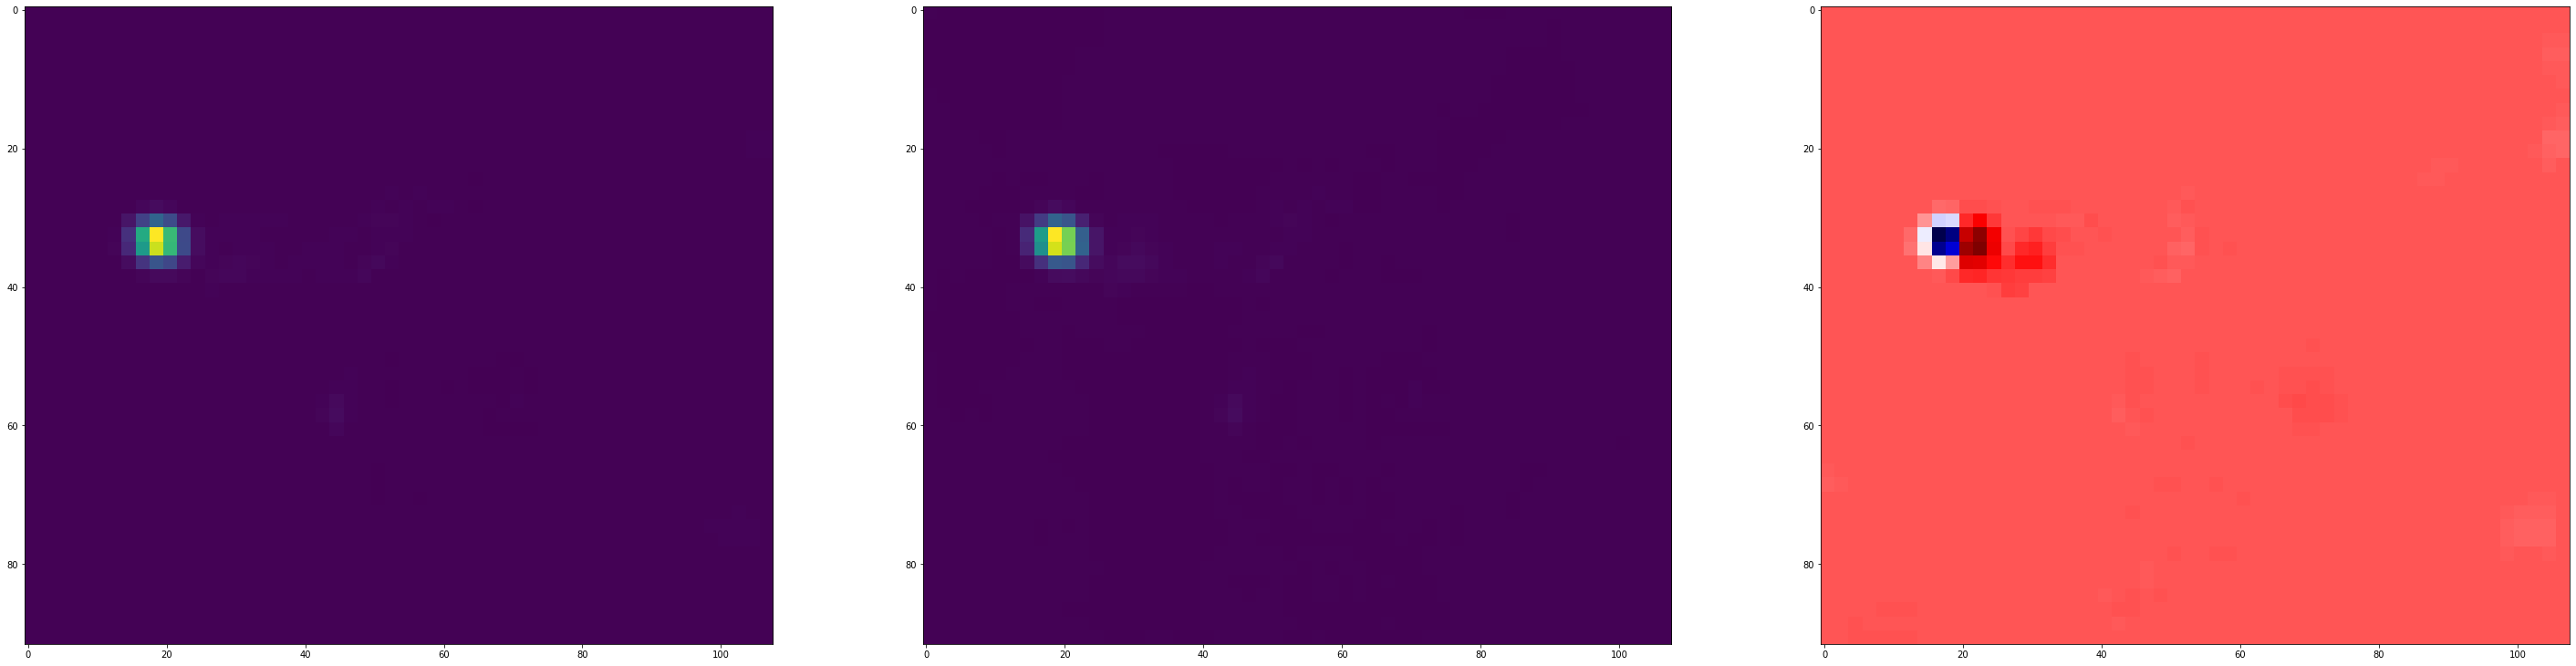

In [75]:
fig = plt.figure(figsize=(50, 25))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(source_np_heat[0,: ,:, CocoPart.RWrist.value])

ax = fig.add_subplot(1, 3, 2)
ax.imshow(e_source.heatMat[:,:, CocoPart.RWrist.value])
print(is_same_image(source_np_heat[0,: ,:, CocoPart.RWrist.value], e_source.heatMat[:,:, CocoPart.RWrist.value]))
ax = fig.add_subplot(1, 3, 3)
ax.imshow(e_source.heatMat[:,:, CocoPart.RWrist.value] - source_np_heat[0,: ,:, CocoPart.RWrist.value], cmap='seismic')
